# **Lane Line Detection** 



**Steps are including choosing region of interest, Gaussian smooth, Canny detection and Hough Transform detection. Finally, add raw image and hough transformed image togethor as the output.**



In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

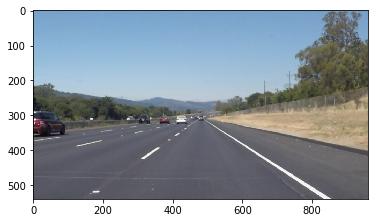

In [7]:
# Input raw graph
image = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(image)  

In [8]:
"""
Self-defined functions to simplify the main function

"""
import math

def grayscale(img):
    """Color in gray"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Use canny to do edge detection"""
    """Hysteresis: use lower and upper threshold to determine whether it's the edge
        a. If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
        b. If a pixel gradient value is below the lower threshold, then it is rejected.
        c. If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
    """
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Gaussian Denoising"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def median_blur(img, kernel_size):  
    """Median Denoising"""
    return cv2.medianBlur(img, kernel_size)
    
def region_of_interest(img, vertices):
    """
    Define figure mask region
    """
    mask = np.zeros_like(img)  # white  
    
    # Given number of figure channels, set the dimention of mask as well as color
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Fill the polygon will color
    # Vertices denote the endpoints for the interested region
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draw straight lines, given the end points coordinates
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def get_y_intercept(lane_lines, slopes):
    """
    Given lines and intercept points, calculate the mean slope
    """
    
    slopes = slopes[~np.isnan(slopes)]
    slopes = slopes[~np.isinf(slopes)]
    avg_slope = slopes.mean()
    lane_lines = lane_lines.reshape((lane_lines.shape[0]*2, lane_lines.shape[1]//2))
    x_mean, y_mean = np.mean(lane_lines, axis=0)
    return y_mean - (x_mean*avg_slope), avg_slope

def get_x_intercepts(y_1, y_2, slope, b):
    """
    Given slope and intercept points, calculate the intercept points in X-axis
    """
    if not (~np.isnan(slope) and ~np.isnan(b)):
        x_1 = x_2 = 0.0
    else:
        x_1 = (y_1 - b)/slope
        x_2 = (y_2 - b)/slope
    return x_1, x_2

prev_left_x1 = 0
prev_left_x2 = 0
prev_right_x1 = 0 
prev_right_x2 = 0 
prev_left_avg_m = 0
prev_right_avg_m = 0
pev_left_avg_m = -1
prev_right_avg_m = 1
prev_left_b = 0
prev_right_b = 0
prev_left_line = 0
prev_right_line = 0

def draw_lines_extrapolated(img, lines, color=[255, 0, 0], thickness=10):
    """
    Connect the piecewise detected lane lines togethoer
    """
    imgshape = img.shape
    lines = lines.reshape((lines.shape[0], lines.shape[2]))
    y_min = lines.reshape((lines.shape[0]*2, lines.shape[1]//2))[:,1].min()
    
    # slope= (    y2      -     y1   )/(    x2     -     x1    )  
    slopes = (lines[:,3] - lines[:,1])/(lines[:,2] - lines[:,0])
    slopes = slopes[~np.isinf(slopes)]  # remove the infinite and invalid slopes
    slopes = slopes[~np.isnan(slopes)]
    left_lines = lines[slopes < -0.5]   # slopes of lane lines on the left side should be negative(0.5 is the hyperparam)
    right_lines= lines[slopes > 0.5]    # slopes of lane lines on the right side should be positive(0.5 is the hyperparam)
    left_slopes = slopes[slopes < -0.5]
    right_slopes= slopes[slopes > 0.5]
    
    global prev_left_avg_m 
    global prev_right_avg_m 
    global prev_left_b
    global prev_right_b
    
    left_b, left_avg_m = get_y_intercept(left_lines, left_slopes)
    right_b, right_avg_m = get_y_intercept(right_lines, right_slopes)

    keep_prev_left = False
    keep_prev_right = False
    
    if left_avg_m < -0.83 or left_avg_m > -0.36:
        left_avg_m = prev_left_avg_m
        left_b = prev_left_b
        keep_prev_left = True
    if right_avg_m > 0.83 or right_avg_m < 0.36:
        right_avg_m = prev_right_avg_m
        right_b = prev_right_b
        keep_prev_right = True
  
    prev_left_avg_m = left_avg_m 
    prev_right_avg_m = right_avg_m
    prev_left_b = left_b
    prev_right_b = right_b

    left_x1, left_x2 = get_x_intercepts(y_1=y_min, y_2=imgshape[0], slope=left_avg_m, b=left_b)
    right_x1, right_x2 = get_x_intercepts(y_1=y_min, y_2=imgshape[0], slope=right_avg_m, b=right_b)
    
    ## Use the idea from optimization function Momentum, here the slope at this moment takes into account the previous slope.
    ## Thus, the current slope is consisted of 20% of new slope added and 80% previous slope.
    global prev_left_x1
    global prev_left_x2
    global prev_right_x1 
    global prev_right_x2 

    if prev_left_x1 != 0 or prev_left_x2 != 0 or prev_right_x1 != 0 or prev_right_x2 !=0:
        alpha = 0.2
        left_x1_new = math.floor((alpha)*left_x1 + (1-alpha)*prev_left_x1)
        left_x2_new = math.floor((alpha)*left_x2 + (1-alpha)*prev_left_x2)
        right_x1_new = math.floor((alpha)*right_x1 + (1-alpha)*prev_right_x1)
        right_x2_new = math.floor((alpha)*right_x2 + (1-alpha)*prev_right_x2)
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new
    else:
        left_x1_new = left_x1
        left_x2_new = left_x2
        right_x1_new = right_x1
        right_x2_new = right_x2
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new

    left_line = np.array([left_x1_new, y_min, left_x2_new, imgshape[0]], dtype=np.int32)
    right_line = np.array([right_x1_new, y_min, right_x2_new, imgshape[0]], dtype=np.int32)
    
    if keep_prev_left:
        left_line = prev_left_line
        left_x1_new = prev_left_x1
        left_x2_new = prev_left_x2
    if keep_prev_right:
        right_line = prev_right_line
        right_x1_new = prev_right_x1
        right_x2_new = prev_right_x2
        
    cv2.line(img, (int(left_x1_new), int(y_min)), (int(left_x2_new), imgshape[0]), color, thickness)
    cv2.line(img, (int(right_x1_new), int(y_min)), (int(right_x2_new), imgshape[0]), color, thickness)        
   
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, extrapolate=False):
    """
    Hough transformation after canny detection.
    Param description:
        dst: Output of the edge detector. It should be a grayscale image (although in fact it is a binary one)
        lines: A vector that will store the parameters (x_{start}, y_{start}, x_{end}, y_{end}) of the detected lines
        rho : The resolution of the parameter r in pixels. We use 1 pixel.
        theta: The resolution of the parameter theta in radians. We use 1 degree (pi/180)
        threshold: The minimum number of intersections to "detect" a line
        minLinLength: The minimum number of points that can form a line. Lines with less than this number of points are disregarded.
        maxLineGap: The maximum gap between two points to be considered in the same line.
    
    Return:
        A black and white image.
    """ 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if not extrapolate:
        draw_lines(line_img, lines)
    elif extrapolate:
        draw_lines_extrapolated(line_img, lines)
    
    return line_img


def weighted_img(img, initial_img, a=0.8, b=1.):
    """
    Param:
        `img`: out_put of hough_lines()
    
        `initial_img` : raw image
    
         a & b: weights of hough image and raw image
    
    Return:
        initial_img * a + img * b 
    """
    return cv2.addWeighted(initial_img, a, img, b, 0)

## Test on test images


In [9]:
import os
os.listdir("test_images/")

['challenge-area-1.png',
 'challenge-area.png',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

##### solidWhiteCurve.jpg  

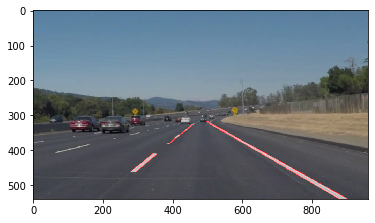

In [10]:
img = mpimg.imread('test_images/solidWhiteCurve.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=20)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, a=0.8, b=1.)
plt.imshow(img_lanes)

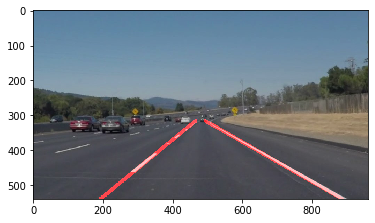

In [11]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=20, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, a =0.8, b=1.)
plt.imshow(img_lanes_extrapolated)

##### solidWhiteRight.jpg 

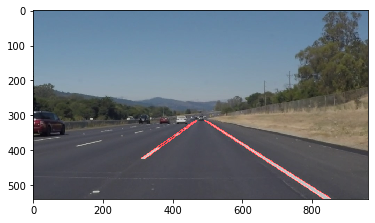

In [12]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=40)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, a=0.8, b=1.)

plt.imshow(img_lanes)

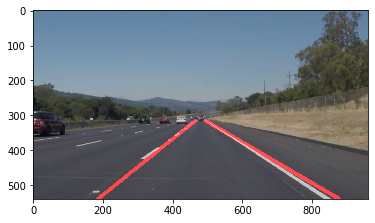

In [13]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=40, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, a=0.8, b=1.)
plt.imshow(img_lanes_extrapolated)